In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [100]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.0001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [118]:
# Get test split
bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
# bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 10)


In [119]:
# Load model
experiments = ['imagery_sample_cnn_regression_ALL']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [120]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-22 23:55:57.116506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[-2.21693218e-01]
 [-1.82649374e-01]
 [-5.97229600e-01]
 [-5.77524960e-01]
 [-2.07736548e-02]
 [-4.09111530e-02]
 [ 1.09390342e+00]
 [-7.33627453e-02]
 [ 1.79218590e-01]
 [-1.07338727e-01]
 [-3.37955743e-01]
 [-3.57654765e-02]
 [-8.73024948e-03]
 [ 1.24204792e-02]
 [ 3.87204848e-02]
 [ 4.65107948e-01]
 [-2.51640588e-01]
 [ 2.97450513e-01]
 [ 6.37090802e-01]
 [ 1.39534876e-01]
 [-5.24175540e-02]
 [-2.49139875e-01]
 [-4.54339921e-01]
 [-4.16165948e-01]
 [-2.77247667e-01]
 [-2.54158050e-01]
 [-8.16569209e-01]
 [ 3.42304260e-02]
 [-6.77130640e-01]
 [-1.62942767e-01]
 [-3.23370546e-01]
 [-2.07623020e-02]
 [-8.21325034e-02]
 [-1.34447706e+00]
 [ 3.31396723e+00]
 [ 3.53522778e-01]
 [-6.62283152e-02]
 [-6.15281641e-01]
 [ 3.10565624e-02]
 [-6.18492067e-02]
 [-6.22180998e-02]
 [-2.19979584e-01]
 [ 3.60160947e-01]
 [-1.56349421e+00]
 [-2.19728276e-01]
 [-2.40746200e-01]
 [-6.84820056e-01]
 [ 1.25166535e-01]
 [-2.07623020e-02]
 [-3.88339208e-03]
 [-1.00623637e-01]
 [-2.13566452e-01]
 [-3.4080363

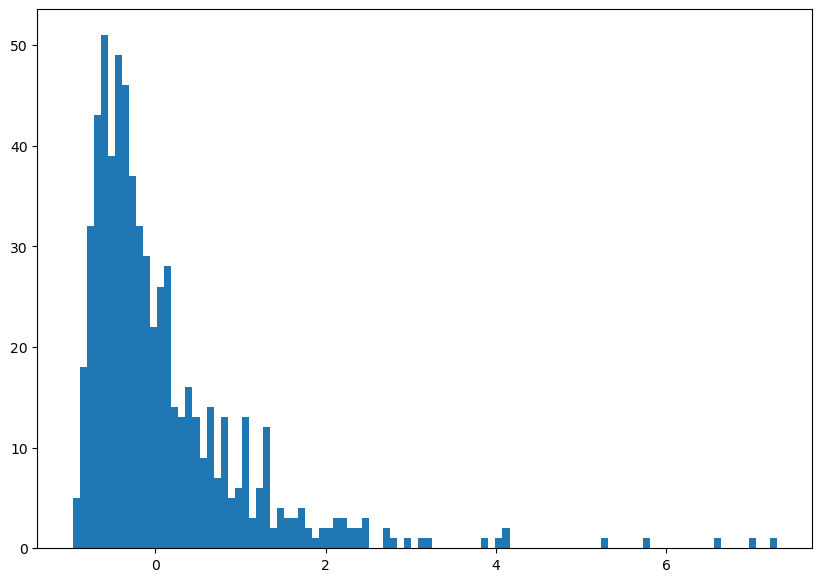

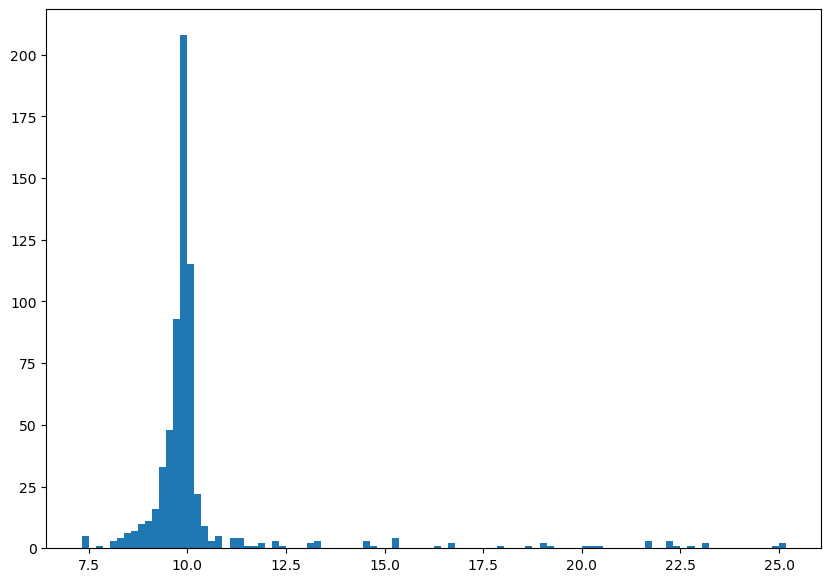

In [121]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds + 10

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1

r2 = pearsonr(y_true, y_preds)[0]

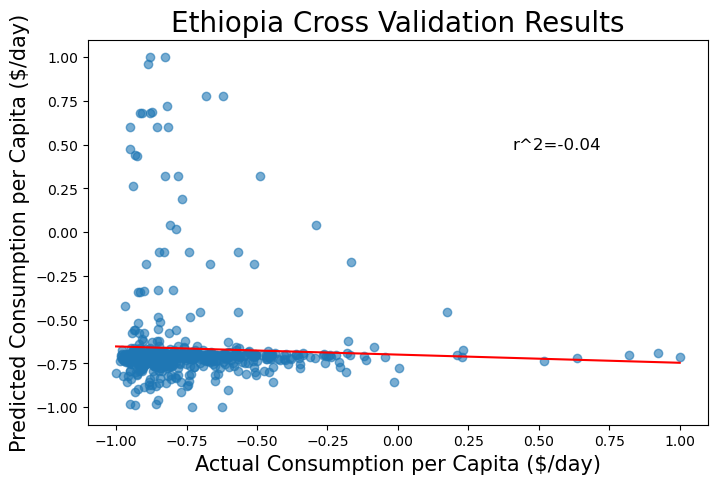

In [122]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()